In [18]:
# find a well performing existing model and apply to our own problem
# where to get pre-trained models: torch<type>.models, HuggingFace Hub

In [19]:
# covering:
# - setup, getting data, datasets and dataloader setup
# - get and customize a pre-trained model, train model
# - eval, predictions

In [20]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from going_modular.going_modular import data_setup, engine

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cpu


In [22]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss"), plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy"), plt.xlabel("Epochs")
    plt.legend()

In [23]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)
    os.remove(data_path/"pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [24]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [25]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [26]:
auto_transforms = weights.transforms()
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=32)
auto_transforms, train_dataloader, test_dataloader, class_names

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ['pizza', 'steak', 'sushi'])

In [27]:
# getting the pre-trained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
#model

In [28]:
# param with requires_grad=False is "untrainable" or "frozen" in place
# next step, change output layer from 1000 classes to 3
for param in model.features.parameters():
    param.requires_grad = False

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [30]:
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [53]:
from timeit import default_timer as timer
start_time = timer()
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 0.8448 | train_acc: 0.7617 | test_loss: 0.8504 | test_acc: 0.7434
Epoch: 2 | train_loss: 0.8379 | train_acc: 0.6953 | test_loss: 0.8328 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7743 | train_acc: 0.8359 | test_loss: 0.8056 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.8158 | train_acc: 0.7070 | test_loss: 0.8056 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7332 | train_acc: 0.8633 | test_loss: 0.7515 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.7463 | train_acc: 0.7461 | test_loss: 0.7272 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.7230 | train_acc: 0.7695 | test_loss: 0.7053 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.6906 | train_acc: 0.8945 | test_loss: 0.6971 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.7195 | train_acc: 0.7539 | test_loss: 0.6923 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.6660 | train_acc: 0.7891 | test_loss: 0.6537 | test_acc: 0.8864
[INFO] Total training time: 84.325 seconds


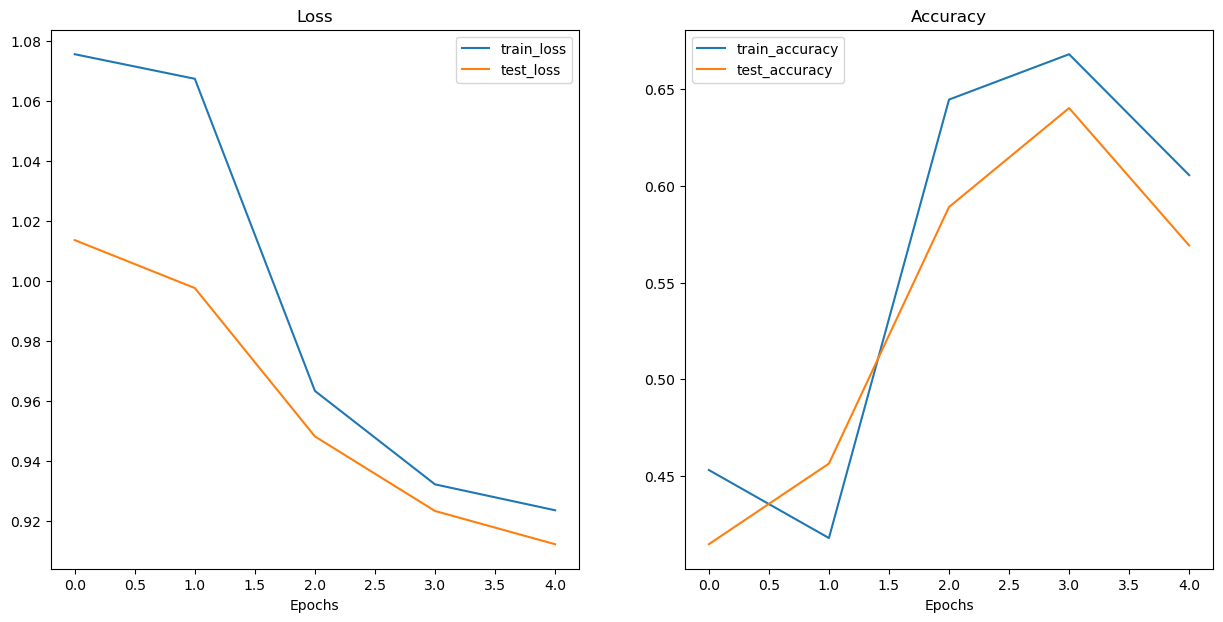

In [33]:
plot_loss_curves(results)

In [49]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        model.to(device)
        model.eval()
        with torch.inference_mode():
            transformed_image = image_transform(img).unsqueeze(dim=0)
            target_image_pred = model(transformed_image.to(device))
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
        
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")

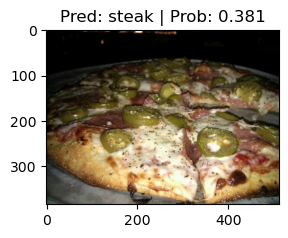

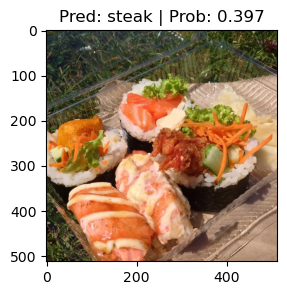

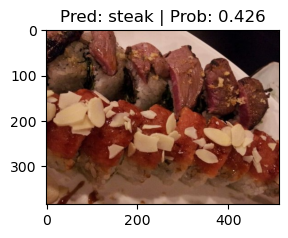

In [52]:
import random
n = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                      k=n)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))